In [48]:
import itertools
import numpy
from scipy.spatial import ConvexHull

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot



# --- Misc. geometry code -----------------------------------------------------

'''
Pick N points uniformly from the unit disc
This sampling algorithm does not use rejection sampling.
'''
def disc_uniform_pick(N):
	angle = (2 * numpy.pi) * numpy.random.random(N)
	out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
	out *= numpy.sqrt(numpy.random.random(N))[:,None] 
	return out



def norm2(X):
	return numpy.sqrt(numpy.sum(X ** 2))



def normalized(X):
	return X / norm2(X)



# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
	return normalized(numpy.cross(A, B) + numpy.cross(B, C) + numpy.cross(C, A))



def get_power_circumcenter(A, B, C):
	N = get_triangle_normal(A, B, C)
	return (-.5 / N[2]) * N[:2]



def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_power_triangulation(S, R):
	# Compute the lifted weighted points
	S_norm = numpy.sum(S ** 2, axis = 1) - R ** 2
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)
#### 
#Aquí se modifican los pesos if exist
	# Special case for 3 points
	if S.shape[0] == 3:
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
		else:
			return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

	# Compute the convex hull of the lifted weighted points
	hull = ConvexHull(S_lifted)
	
	# Extract the Delaunay triangulation from the lower hull
	tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
	
	# Compute the Voronoi points
	V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

	# Job done
	return tri_list, V



# --- Compute Voronoi cells ---------------------------------------------------

'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''
def get_voronoi_cells(S, V, tri_list):
	# Keep track of which circles are included in the triangulation
	vertices_set = frozenset(itertools.chain(*tri_list))

	# Keep track of which edge separate which triangles
	edge_map = { }
	for i, tri in enumerate(tri_list):
		for edge in itertools.combinations(tri, 2):
			edge = tuple(sorted(edge))
			if edge in edge_map:
				edge_map[edge].append(i)
			else:
				edge_map[edge] = [i]

	# For each triangle
	voronoi_cell_map = { i : [] for i in vertices_set }

	for i, (a, b, c) in enumerate(tri_list):
		# For each edge of the triangle
		for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
		# Finite Voronoi edge
			edge = tuple(sorted((u, v)))
			if len(edge_map[edge]) == 2:
				j, k = edge_map[edge]
				if k == i:
					j, k = k, j
				
				# Compute the segment parameters
				U = V[k] - V[j]
				U_norm = norm2(U)				

				# Add the segment
				voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
			else: 
			# Infinite Voronoi edge
				# Compute the segment parameters
				A, B, C, D = S[u], S[v], S[w], V[i]
				U = normalized(B - A)
				I = A + numpy.dot(D - A, U) * U
				W = normalized(I - D)
				if numpy.dot(W, I - C) < 0:
					W = -W	
			
				# Add the segment
				voronoi_cell_map[u].append(((edge_map[edge][0], -1), (D,  W, 0, None)))				
				voronoi_cell_map[v].append(((-1, edge_map[edge][0]), (D, -W, None, 0)))				

	# Order the segments
	def order_segment_list(segment_list):
		# Pick the first element
		first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

		# In-place ordering
		segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
		for i in range(len(segment_list) - 1):
			for j in range(i + 1, len(segment_list)):
				if segment_list[i][0][1] == segment_list[j][0][0]:
					segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
					break

		# Job done
		return segment_list

	# Job done
	return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }



# --- Plot all the things -----------------------------------------------------

def display(S, R, tri_list, voronoi_cell_map):
	# Setup
	fig, ax = plot.subplots()
	plot.axis('equal')
	plot.axis('off')	

	# Set min/max display size, as Matplotlib does it wrong
	min_corner = numpy.amin(S, axis = 0) - numpy.max(R)
	max_corner = numpy.amax(S, axis = 0) + numpy.max(R)
	plot.xlim((min_corner[0], max_corner[0]))
	plot.ylim((min_corner[1], max_corner[1]))

	# Plot the samples
	for Si, Ri in zip(S, R):
		ax.add_artist(plot.Circle(Si, Ri, fill = True, alpha = .3, lw = 0., color = '#FF2E00', zorder = 1))

	# Plot the power triangulation
#	edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
#	line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.9')
#	line_list.set_zorder(0)
#	ax.add_collection(line_list)
	#print(line_list)
	# Plot the Voronoi cells
	edge_map = {}
	for segment_list in voronoi_cell_map.values():
		for edge, (A, U, tmin, tmax) in segment_list:
			edge = tuple(sorted(edge))
			if edge not in edge_map:
				if tmax is None:
					tmax = 10
				if tmin is None:
					tmin = -10

				edge_map[edge] = (A + tmin * U, A + tmax * U)
	valores=edge_map.values()
	line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Job done
	plot.show()

	return valores

  

# --- Main entry point --------------------------------------------------------

def main(puntos):
	# Generate samples, S contains circles center, R contains circles radius
	#sample_count = 32
	sample_count = len(puntos)   
	S = 20* disc_uniform_pick(sample_count) 
	#print(S) 
    #puntos
	R = .8 * numpy.random.random(sample_count) + .2

	# Compute the power triangulation of the circles
	tri_list, V = get_power_triangulation(S, R)

	# Compute the Voronoi cells
	voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

	# Display the result
	#display(S, R, tri_list, voronoi_cell_map)

	return display(S, R, tri_list, voronoi_cell_map),S,R
#if __name__ == '__main__':
#	main()

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import geopandas as gpd
import contextily as cx
import folium

In [50]:
path=('Data/centros-de-salud/Centros de Salud/Centros_de_salud.shp')

In [51]:
df_sk1 = gpd.read_file(path)

In [52]:
Out_Op=df_sk1[df_sk1['ESTATU_OPE']=='FUERA DE OPERACIÓN (TOTAL O PARCIAL)'].geometry
geo_df_list_menus=[[point.xy[1][0],point.xy[0][0]] for point in Out_Op]
#geo_df_list=[[point.xy[1][0],point.xy[0][0]] for point in df_sk1]

In [53]:
skt_points=np.array(geo_df_list_menus)

In [54]:
skt_points=[point for point in geo_df_list_menus if point not in geo_df_list_menus] 

In [83]:
skt_points_trans=[]
for i in range(len(skt_points)):
    skt_points_trans.append([skt_points[i][1],skt_points[i][0]])

In [56]:
skt_points=np.array(skt_points)

In [57]:
A0=skt_points[:,0].min()
B0=skt_points[:,0].max()
A1=skt_points[:,1].min()
B1=skt_points[:,1].max()


#pun_rep=np.zeros((len(skt_points),2))

#for i in range(len(skt_points)):
    #print(i)
    #print(skt_points[i,0],skt_points[i,1])

#    pun_rep[i,0]=(((4.9-(-4.9))/(B0-A0))*(skt_points[i,0]-A0))-4.9
#    pun_rep[i,1]=(((4.9-(-4.9))/(B1-A1))*(skt_points[i,1]-A1))-4.9
#pun_rep

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [58]:
A0,B0,A1,B1

NameError: name 'A0' is not defined

In [59]:
graph,loc,rad=main(skt_points)

ValueError: No points given

In [60]:
def nuevo_loc(x):
    A0,B0,A1,B1=19.248, 19.5117, -99.2884, -99.0095
    #print(x[1])
    x1_old=x[0]
    y1_old=x[1]

    x1_new = (x1_old  + 4.9)*((B0-A0)/(4.9-(-4.9)))+A0
    
    y1_new= (y1_old  + 4.9)*((B1-A1)/(4.9-(-4.9)))+A1
    #print([x1_new,y1_new]) 
    return ([y1_new,x1_new])

In [61]:
j=0
location_new=[]
for punto in loc:
    location_new.append(nuevo_loc(punto))
    

NameError: name 'loc' is not defined

In [62]:
lista_rep_x=[]
lista_rep_y=[]
for i in range(len(location_new)):
    lista_rep_x.append(location_new[i][0])
    lista_rep_y.append(location_new[i][1])

In [63]:
inter_x_new=abs(min(lista_rep_x)-max(lista_rep_x))
inter_y_new=abs(min(lista_rep_y)-max(lista_rep_y))
inter_x_old=abs(B1-A1)
inter_y_old=abs(A0-B0)

ValueError: min() arg is an empty sequence

In [64]:
inter_x_old/inter_x_new

NameError: name 'inter_x_old' is not defined

In [65]:
inter_y_old/inter_y_new

NameError: name 'inter_y_old' is not defined

In [66]:
rad

NameError: name 'rad' is not defined

In [67]:
camb_tam=((((B0-A0)**2)+((B1-A1)**2))**1/2)/(9.8**2)

NameError: name 'B0' is not defined

In [68]:
rad=rad*camb_tam

NameError: name 'rad' is not defined

In [69]:
def nuevo_punto(x):
    A0,B0,A1,B1=19.248, 19.5117, -99.2884, -99.0095
    x1_old=x[0][0] 
    x2_old=x[1][0]
    y1_old=x[0][1]
    y2_old=x[1][1]
    
    x1_new = ((x1_old  + 4.9)*((B0-A0)/(4.9-(-4.9)))+A0)#*(1-0.0000009032839523638492)
    x2_new = ((x2_old  + 4.9)*((B0-A0)/(4.9-(-4.9)))+A0)#*(1-0.00000092839523638492)
    
    y1_new= ((y1_old  + 4.9)*((B1-A1)/(4.9-(-4.9)))+A1)#*(1-0.0000009032839523638492)
    y2_new= ((y2_old  + 4.9)*((B1-A1)/(4.9-(-4.9)))+A1)#*(1-0.0000009032839523638492)
    return ([y1_new,x1_new],[y2_new,x2_new])

In [70]:
dict_new={}
j=0
for i in graph:
    dict_new[j]=nuevo_punto(i)
    #print(dict_new[j])
    j=j+1
    #inicio del 

NameError: name 'graph' is not defined

In [71]:


#####################################################################################

In [72]:
from math import ceil
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(sys.version)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)
print(np.__name__, np.__version__)
print(plt.matplotlib.__name__, plt.matplotlib.__version__)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
geopandas 0.12.2
numpy 1.21.5
matplotlib 3.5.2


In [73]:
from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

In [74]:
path2=('Data/us_8.shp')
df_sk2 = gpd.read_file(path2)

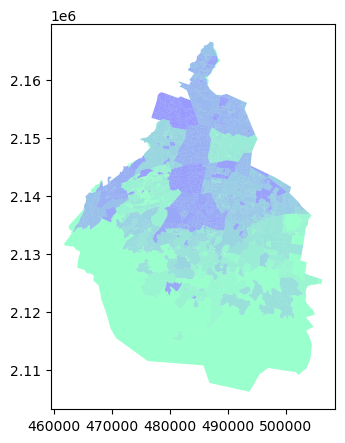

In [75]:
pob = df_sk2.plot(figsize=(5, 5),cmap='winter', alpha=0.4)
#ax.add_collection(graph)


In [76]:
from matplotlib.collections import LineCollection

In [77]:
path4=('Data/alcaldias_cdmx.shp')
df_sk4 = gpd.read_file(path4)

In [78]:
df_sk4.head()

,geometry
0,"POLYGON ((-98.99723 19.22731, -98.99745 19.227..."
1,"POLYGON ((-99.13679 19.40156, -99.13682 19.401..."
2,"POLYGON ((-99.11860 19.58446, -99.11691 19.581..."
3,"POLYGON ((-99.13923 19.35687, -99.13772 19.356..."
4,"POLYGON ((-99.19058 19.46794, -99.19066 19.465..."


<AxesSubplot:>

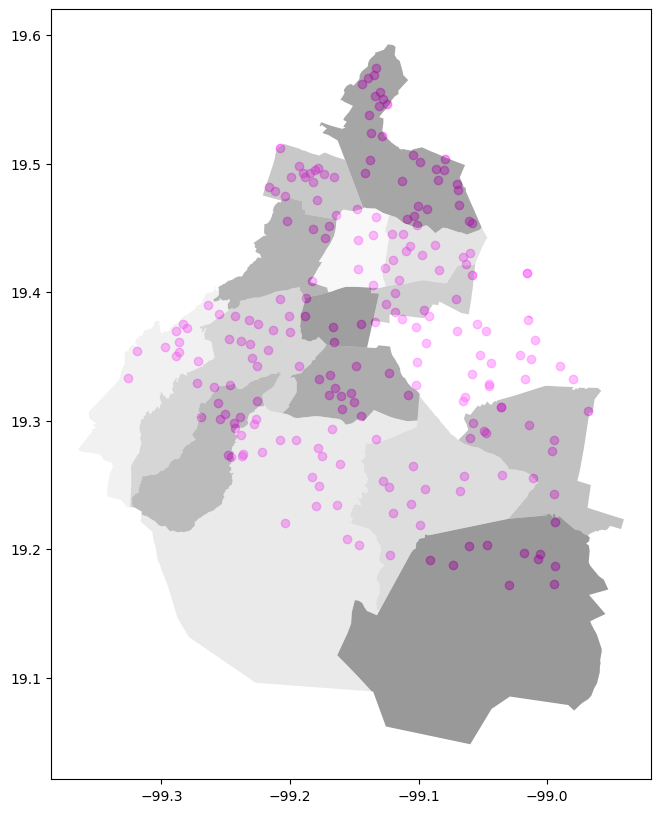

In [79]:

fig, ax =plt.subplots(figsize =(10,10))
df_sk1.plot(figsize=(5, 5),color='Magenta', alpha=0.4,ax=ax)
df_sk4.plot(figsize=(5, 5),cmap='gray', alpha=0.4,ax=ax)
#ax.set_axis_on()

In [42]:
location_newA=skt_points

In [45]:
#print(dict_new.values())

fig, ax = plot.subplots()
plot.axis('equal')
plot.axis('off')

	# Set min/max display size, as Matplotlib does it wrong
min_corner = numpy.amin(location_newA, axis = 0) - numpy.max(rad)
max_corner = numpy.amax(location_newA, axis = 0) + numpy.max(rad)
plot.ylim((min_corner[0], max_corner[0]))
plot.xlim((min_corner[1], max_corner[1]))
for Si, Ri in zip(skt_points, rad):
    ax.add_artist(plot.Circle(Si, Ri, fill = True, alpha = .3, lw = 0., color = '#FF2E00', zorder = 1))
newline_list = LineCollection(dict_new.values(), lw = 1., colors = 'k')
newline_list.set_zorder(0)
#df_sk1.plot(color='Magenta', alpha=0.4,ax=ax)
#df_sk4.plot(cmap='gray', alpha=0.4,ax=ax)
ax.add_collection(newline_list)

NameError: name 'plot' is not defined

# Voronoi + Folium

In [84]:
map = folium.Map(location=[19.432, -99.133], tiles="OpenStreetMap", zoom_start=9, max_zoom = 16, min_zoom=10)

# Se crea una lista con los puntos coordenadas

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_sk1.geometry]

#print(geo_df_list)

#se itera en el conjunto de puntos
for coordinates in geo_df_list:
    
    if coordinates in geo_df_list_menus:
         folium.CircleMarker(
        location=coordinates,
        radius=2.5,
        color="#E7625F",
        fill=True,
        fill_color="#E7625F",).add_to(map)
    else:    
    
        folium.CircleMarker(
        location=coordinates,
        radius=5,
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",).add_to(map)
map

In [82]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

points = skt_points_trans
#vor = Voronoi(points)
print(points) 
#fig, ax = plot.subplots(figsize =(10,10))
#fig2=voronoi_plot_2d(vor,ax=ax,show_vertices=False, line_colors='k',line_width=1, line_alpha=0.1)
#df_sk4.plot(color='blue', alpha=0.2,ax=ax)
#plt.show()

[]


In [790]:
from geojson import FeatureCollection, Feature, Polygon

In [821]:
m=folium.Map(location=[19.432, -99.133], tiles="OpenStreetMap", zoom_start=9, max_zoom = 16, min_zoom=10)
point_voronoi_list = []
feature_list = []
for region in range(len(vor.regions)-1):
    vertex_list = []
    for x in vor.regions[region]:
        if x == -1:
            break;
        else:
            #Get the vertex out of the list, and flip the order for folium:
            vertex = vor.vertices[x]
            vertex = (vertex[1], vertex[0])
        vertex_list.append(vertex)
    #Save the vertex list as a polygon and then add to the feature_list:
        polygon = Polygon([vertex_list])

    feature = Feature(geometry=polygon, properties={})
    folium.Polygon(polygon['coordinates']).add_to(m)
    #print(polygon['coordinates'])
    feature_list.append(feature)
#geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in df_sk1.geometry]

#print(geo_df_list)

#se itera en el conjunto de puntos
for coordinates in skt_points:
    folium.CircleMarker(location=coordinates, radius=5,color="#E7625F", fill=True, fill_color="#E7625F",).add_to(m)


In [822]:
m

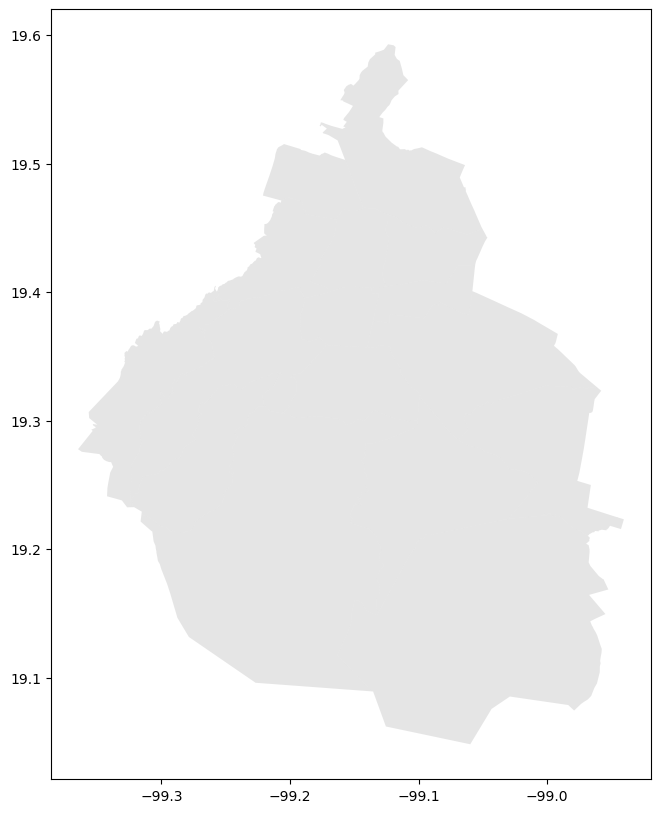

In [828]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

points = skt_points_trans
vor = Voronoi(points)

fig, ax = plot.subplots(figsize =(10,10))
#fig2=voronoi_plot_2d(vor,ax=ax,show_vertices=False, line_colors='k',line_width=1, line_alpha=0.1)
df_sk4.plot(color='grey', alpha=0.2,ax=ax)
plt.show()